# Tanzanian Water Well Classification Analysis

#### By Jonny Hofmeister

This data comes from Taarifa, an open source platform that tracks infrastucture related issues and data, who has sourced this data from the Tanzanian Ministry of Water. It is posted on the [DRIVENDATA](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) site as a classification data science contest.

###### This project will utilize the CRISP-DM process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from category_encoders import CountEncoder

from functions import metrics_matrix

In [3]:
# import data
dftarget = pd.read_csv('data/train_target.csv')
dfvalues = pd.read_csv('data/train_values.csv')

# merge on id
df = pd.merge(dftarget, dfvalues, how='inner', on='id')

## Business Understanding

The goal of this classification model is to predict the functional status of water well pumps in Tanzania. We are supplied with ample data for well pumps with known functionality, but there are many others out there whose functionality is unknown. We will try to mine this data for insights that can help the Tanzanian Ministry of Water predict if wells with unknown functionality are working or not. This information will help them to understand and determine the best practices for addressing repair of wells throughout the country. 

The first goal of this project is to supply a prediction model with ample accuracy so that the Tanzanian government and associated groups can analyze their next steps with a more complete understanding of well functionality accross the country. 

After building a successful prediction model, the next steps are to help the Tanzanian Ministry of Water determine the most efficient ways to go about repairing wells that need repair. Given the remote areas and limited repair labor, they must determine how to prioritize repair in areas and wells that would maximize the utility of their mission. 

## Data Understanding

### Target

The classification target of well status given in the data is grouped into three classes: 'functional', 'non-functional', and 'functional needs repair'. This classification problem could reduced to binary targets (ones needing repair or not), but given that TMW might want to prioritize completely non-functional wells over functional-needs-repair ones, we will use a ternary classification model. 

Target classes and frequencies are shown below.

In [4]:
df['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

#### Evaluation Metrics

We also must address the metric on which we will measure the success of the classification model. Given different contexts for problems, one may prefer to maximize precision or recall, or perhaps order and ROC-AUC score. In this problem, I dont believe either a false positive or a false negative is worse than the other. Identifying a non-working well as working means that the well would be missed by the TSM and repair teams - this isn't good. But, identifying a working well as not-working means you may end up sending a repair person to a working well and this could mean that there isn't time to go find and fix a well that is truly broken (there are thousands of wells so we must assume the TSM will not get to every well that needs repair). In both FP/FN cases it is possible that a well that needs repair doesn't get it, and for this reason, this model will focus on maximizing the F1 score, which balances both precision and recall. 


### Features

There are around 40 features given in the original dataset. They contain both numerical and categorical information. Many of the features are repetitive though, for example, 'extraction_type', 'extraction_type_class', and 'extraction_type_group' are almost identical. Each contains multiple of the same classes but 'class' or 'group' may have an extra couple labels created in place of a previous label. Because all of these reduntant features, we must decide which ones to use in modeling to avoid colinearities. 

In [5]:
# the 'duplicate' columns can easily be seen in a list
list(df.columns)

['id',
 'status_group',
 'amount_tsh',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

I have explored and selected this list below, which removes 'duplicate' type columns but still keeps one from each group. I would consider this data to encompass the whole dataset - just without colinearities. Refining further and removing columns without much variance is an option I may explore after creating some models.

In [6]:
keep_columns = ['status_group', 'amount_tsh', 'gps_height', 'num_private', 'region', 'district_code', 'lga',
                'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type',
                'management_group', 'water_quality', 'quantity', 'source', 'waterpoint_type', 
                'population']

df = df[keep_columns]

### Description of Columns
Here are brief descriptions of the columns selected.
- 'amount_tsh': Total Static Head - the height of the water column produced by the pressure of the pump.
- 'gps_height': The altitude of the pump.
- 'num_private': No description given - possibly number of private entities (companies groups), using this well.
- 'region': The geographical region the pump is located in.
- 'district_code': The district (coded) pump is located in.
- 'lga': Another geographical region description (more specific than the two above).
- 'public_meeting': Boolean - if there has been a public meeting where this well has been addressed.
- 'scheme_management': Group who operates the well.
- 'permit': Boolean - if the well has a permit or not.
- 'construction_year': The year the well was created.
- 'extraction_type': The type of water extraction the well uses.
- 'management_group': Like scheme management, but if that group is commercial or user-based.
- 'water_quality': The quality of water at that well.
- 'quantity': How much water is available to the pump - categorical.
- 'source': The water source type for the waterpoint (groundwater, rainwater, etc).
- 'waterpoint_type': Type of waterpoint access (handpump, spring, etc).
- 'population': The population near the well.

### Exploring correlation between features

A heat map is a good way to technically examine relationships and multicolinearities.

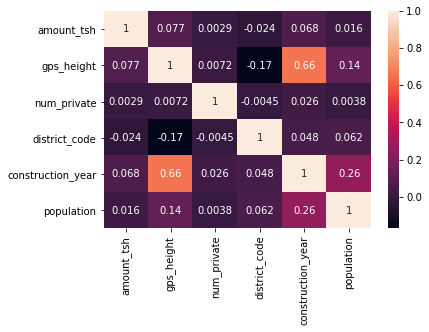

In [7]:
# Very simple to use df.corr to get correlations between the numerical features
corr = df.corr()

# Use seaborn's heatmap to visualize
sn.heatmap(corr, annot=True)
plt.show()

The numericals do not show much correlation at all. There is one pair, construction year and gps height, that oddly have a higher correlation of 0.66. I find this odd and do not know why - but this relationship could influence the decision to remove gps height in a future model as I don't expect it be be able to explain pump status as well as others.

Population and construction year show the next highest correlation - 0.26. This could be influenced by an increasing population in later years, better census reporting in later years, or more urban waterpoint development in later years. This correlation is low enough that I would not consider removing either.

## Data Preparation

#### Missing Values

I have chosen the columns above over their counterparts for certain reasons, the main one being missing values. These columns contain less NaNs or missing groups than the others, so using these will give us access to more of our data in training than the other. Note: other columns may contain their own 'unknown' group, but only these contain actual NaN values that will throw errors in our modeling and must be grouped and labeled or removed. 

In [8]:
df[['public_meeting', 'scheme_management', 'permit']].isna().sum()

public_meeting       3334
scheme_management    3877
permit               3056
dtype: int64

Of the remaining columns only 3 contain NaNs - public_meeting, permit, and scheme_management - and around 3-4 thousand missing values for each. 

The missing values in scheme_management can be easily imputed in preprocessing, so these will be left in order to preserve more rows of data. The public_meeting and permit columns are a bit trickier to deal with since they are boolean True/False values. If we wanted to impute and group the NaNs into an 'unknown' category, the model could no longer view it as a single column of 1s and 0s - we would be forced to one hot encode and turn 1 column to 3, or to frequency encode. 

In [9]:
df['permit'].fillna(False, inplace=True)
df['public_meeting'].fillna(False, inplace=True)

I think the best option is to fill the missing values with False. We retain all the rows that would be sacrificed and the True values for having a permit or a public meeting. The False column has now become 'no' or 'unknown'. This way also keeps the feature to one column instead of three which I think is redundant and excessive.

#### Data Types

The last main part of data preparation is to deal with different data types in the features. We have a few numerical columns that must be imputed for missing values and scaled. The majority of the columns are categorical data -  these can be dealt with in multiple ways. One Hot Encoding is a good option, but not for a dozen columns with dozens of values. The best way to handle this is to select important colummns that have fewer numbers of values to One Hot Encode, and then trasnform the others with some kind of Frequency or Count encoder. Target Encoding or LeaveOneOut encoding is another successful way to encode how frequency of a value relates to the probability of a target class. These forms of encoding all remain one column - making it a good way to include categorical columns without creating more features. 

Let's start by looping through the columns to extract different data types. We will set a threshold value for the number of categories in a categorical column to decide if it will be One Hot Encoded or frequency encoded. 

In [10]:
# First split the data into features and target
X = df.drop('status_group', axis=1)
y = df['status_group']

# We also need to first change the datatype of the district code column
# It is numeric, but we want to treat it as categorical
X['district_code'] = X['district_code'].astype('object')

# Create arrays for different column types
num_cols = []
ohe_cols = []
bool_cols = []
freq_cols = []

# Set a threshold value for the maximum number of unqiue values we want to OHE
thresh = 7


# Loop through the columns and append col to proper list
for col in X.columns:
    
    if X[col].dtype in ['float64', 'int64']:
        num_cols.append(col)
        continue
        
    elif X[col].dtype == 'bool':
        bool_cols.append(col)
        continue
    
    elif X[col].dtype == 'object':
        if len(X[col].unique()) > thresh:
            freq_cols.append(col)
        elif len(X[col].unique()) <= thresh:
            ohe_cols.append(col)

## Preprocessing

In order to smoothly process all the columns at once, we will define some processing steps into piplines and then apply those to a column transformer which will easily manipulate our training data. Because we don't want any "leakage" while scaling and processing the data, the very important Train / Test split will go right here.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

#### Numeric Columns

First I will define the processing steps for the numeric columns. But we may want to treat those numerics slightly differently so lets consider some things first. 

The construction year column contains a decent amount of zero columns - we will deal with these by imputing them with the median year. We dont want to replace zeros in the other columns with their median though,because we cannot be sure if the zero is the actual value or a NaN placeholder like it is for a construction year. Because year is ordinal/interval, I will scale it using a Min/Max scaler. 

The num_cols list created above will have to be broken up into more specific list to deal with the difference in numeric types.

In [12]:
year_col = ['construction_year']

year_scaler = Pipeline(steps=[
    ('year_imputer', SimpleImputer(missing_values=0, strategy='median')),
    ('year_scaler', MinMaxScaler())])

The rest of the numeric columns will use not impute any values and use a Min Max scaler, and we dont have any NaNs to fill, so we dont need a pipeline here, we can just call the scaler we want in the column transformers. But we still need a list of those columns:

In [13]:
num_cols = ['amount_tsh', 'gps_height', 'num_private', 'population']

#### Frequency Encoding Columns

The steps to process frequency encoded columns are simple. Impute the NaNs (only contained in scheme_management currently) into an 'unknown' group, and then transform using a normalized count encoder. 

In [14]:
freq_encoder = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('freq_enc', CountEncoder(normalize=True, min_group_size=0.01, min_group_name='unknown'))
])

#### One Hot Columns

One hot encoding is fairly straight forward and could be one step. But, because we may change the threshold for one hot ecoding and could encounter the scheme management column with NaNs, I am going to add a simple imputer step to deal with it. This will not effect any of the other columns.

In [15]:
ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohencoder', OneHotEncoder(handle_unknown='ignore'))])

#### Boolean Columns

Since our True/False columns already contain no NaNs and can be hanlded by sklearn models, we dont need to define any steps to preprocess them. In our column transformer, they will be left out of the columns list, but setting remainder to 'passthrough' will make sure they move along into the processed dataframe untouched. 

#### Preprocessor

We can now use Sklearns Column Transformer to easily perform all these steps on their respective columns at once.

In [16]:
preprocessor = ColumnTransformer(transformers=[
    ('year', year_scaler, year_col),
    ('num', MinMaxScaler(), num_cols),
    ('freq', freq_encoder, freq_cols),
    ('ohe', ohe_transformer, ohe_cols)],
    remainder='passthrough')

#  Modeling

### Baseline
In order to evaluate the success of following models, we create a baseline to compare to. The most naive baseline is to predict the majority class. Here, if we predicted every well to be functional, we would be correct about 54% of the time. But this baseline model is useless in practice -- if we assumed all are functional then how would we go about repairing the ones that are non-functional?

We can create a better simple baseline model that predicts 2 classes and could be actionable by the TMW to some degree. Let's take the column that measures total static head of the pump ('amount_tsh') and wherever it is zero, predict 'non-functional', and wherever it is greater than zero, predict 'functional'. We can compute our success rate for this model below:

In [17]:
# Number correct is number of functional pumps with tsh > 0 and non-functional pumps with tsh=0.
func_correct = len(df[(df['amount_tsh']>0) & (df['status_group']=='functional')])
nonfunc_correct = len(df[(df['amount_tsh']==0) & (df['status_group']=='non functional')])

# Add totals
total_correct = func_correct + nonfunc_correct
print(f'Total Static Head guess baseline accuracy: {total_correct/len(df):.2}%')

Total Static Head guess baseline accuracy: 0.53%


This may be a lower accuaracy than the 54% majority class, but is at least actionable in terms of understanding if pumps are working or not. If they decided to go fix every pump labeled non-functional in this model, slightly over half of these pumps would be broken or in need of repair. We would have guessed 36,428 as non-functional, 16,555 would acutally be non-functional, and a lucky 2637 would be functional in need of repair. This adds up to a repair efficiency of 52.6%, which happens to be right on par with our overall prediction accuracy for this model. 

But, this doesn't take in to account the 3794 non-functional pumps with a TSH greater than zero we mis-labeled. While this number is smaller than expected, we would still like to be more accurate in order to identify all broken pumps and to make sure we dont waste any time going to fix functional ones (maximising both precision and recall). 

For now, if a model is worthwhile or not will be determined by if we can beat that 53% accuracy above. 

## First Model: K-Nearest Neighbors

The first model we will explore is K-Nearest Neighbors. Computing distance and similarity between rows seems like it could yeild some useful results. Unfortunately this will also require quite a lot of time considering both the number of rows and columns we have. If no others perform well and this does, it may be worth trying to reduce the number of columns in order to perform a grid search and improve the KNN.

Because we have predefined our processing steps, we can call a simple pipeline that processes and then fits the data to a Sklearn KNN model.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
knn_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('knn', KNeighborsClassifier())])

knn_clf.fit(X_train,y_train);

I tried a few versions of the K-Neighbors Classifier with different hyperparameters. The main one to adjust in a KNN model is n_neighbors, which selects the number of nearest neighbors the model should take into account (and their votes) for the predicted class of the sample. I did not run a whole grid search, but jsut tried a few values for n_neighbors and the best perfoming was 5, which is the default value in Sklearn's KNN model, this is why there are no hyperparameters defined in the above step.

## Model 2: Random Forest

I think a random forest will be a good way to mine insights from this data. Thinking back to the baseline model we created, a decision tree works in the same way. Only using one if statement - if amount_tsh > 0, predict functional - we were able to achieve 53% accuracy. Following this same logic, perhaps a few more layers of decision based sorting can lead to sucessful predictions. Another benefit is it is slightly faster than KNN, making a grid search less daunting.

In [20]:
from sklearn.ensemble import RandomForestClassifier

You can see below I have defined a few of the hyperparameters for the random forest model. I ran a few Grid Search CVs to see if we could bump up the model performance a bit, and to decrease overfitting - which tree based models are known to do.

I will comment on the effects of these parameter choices in the evaluation section. 

In [21]:
forest_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(random_state=1234,
                                                              n_estimators=160,
                                                              min_samples_split=2,
                                                              min_samples_leaf=2,
                                                              max_depth=30))])

forest_clf.fit(X_train, y_train);

## Model 3: Support Vector Classifier

The third model we will test is a SVC. The reason for trying a SVC is to a grid search with SVCs different kernel options. This machine learning algorithm manipulates feature space in ways that the previous two models cannot. In my opinion it is worth searching these to see if one is promising enough to continue with.

In [22]:
from sklearn.svm import SVC

In [23]:
svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', SVC(kernel='rbf'))])

svc_clf.fit(X_train, y_train);

# Evaluation

I have created a function that quickly predicts values for the given classifier, calculates and prints our desired metrics, and plots a confusion matrix of the results. I will use this to quickly evaluate each model.

### KNN Model:

Train Scores:
       Accurary = 0.81   F1 Score = 0.8
        Precision = 0.8   Recall = 0.81
        
        ----------------
        
Test Scores:
       Accurary = 0.76   F1 Score = 0.75
        Precision = 0.75   Recall = 0.76
        


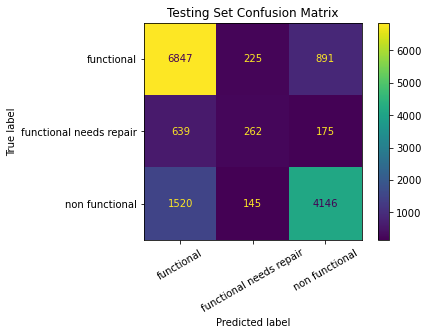

In [24]:
metrics_matrix(knn_clf, X_train, y_train, X_test, y_test)

The K-Nearest Neighbors models actually performed very well right off the bat, and did not take as long as expected to train. Generating predictions for it took much longer. 

An F1 score of 0.75 and an accuracy of 0.76 is much better than the baseline model. This model balanced precision and recall very well, but we can see in the confusion matrix we predicted about twice as many broken wells as functional than we predicted functional wells as broken. We can also see in the confusion matrix that only 262 of the 1076 'functional needs repair' pumps in the testing set correctly. The model was much more likely to classify them as functional. 

One thing to note is it is significantly less over-fit than the tree based model. But, there isn't as much parameter tuning we can use to improve testing scores. Next steps for this model are the same as the random forest, improve the data going in to improve predictions. These scores are close enough to the random forest model that I would certainly attempt both on improved datasets. 


### Random Forest Model

Train Scores:
       Accurary = 0.86   F1 Score = 0.86
        Precision = 0.87   Recall = 0.86
        
        ----------------
        
Test Scores:
       Accurary = 0.8   F1 Score = 0.78
        Precision = 0.8   Recall = 0.8
        


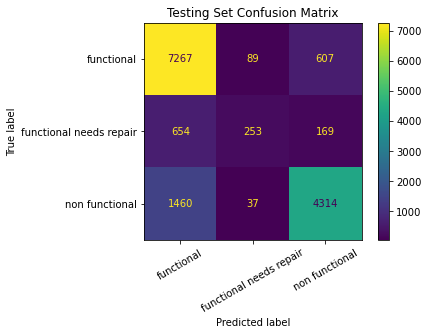

In [25]:
metrics_matrix(forest_clf, X_train, y_train, X_test, y_test)

The Random Forest model performed the best out of the three, with the highest accuracy and F1 scores of .8 and .78 on the testing set. Looking at the confusion matrix, we see almost the same patterns as above -- non-functional predicted as functional about twice as much and funtional was predicted non-functional (this pattern is also due in part to class imbalances). The functional needs repair class was predicted mostly as functional. Given these same patterns, the tree based model did fit about 4% better than the KNN. 

Initially, the training scores for the random forest were as high as .94-.96 (as can be expected from this model), so I used some parameter tuning to reduce this.

Raising the number of n_estimators is a good way to reduce overfitting. Bumping up from 100 estimators to anywhere in the 160-200 range decreased the training scores by about .08 and raised the testing score .01-.02. Raising the minimum leaf samples from 1, and limiting the depth of the tree can also help us generalize a bit more. Overall, this combination of parameters raised the F1 score by .02 - helpful, but not huge. 

I performed more extensive grid searches around these paramters and found that most combinations in this range all improved the testing F1 by about that same 0.02 from a model without defining parameters. I also noticed that at this point, the random state of the model was influencing these tiny bumps and dips in score as much as the other hyperparameters, so I decided we must have reached a limit on how well a random forest model can perform on the current state of the data.

I like a tree based model for this problem, but we have hit the ceiling for parameter tuning. My next steps for this model would be to adjust the data going into it in order to make a more generalizable model. Having unnessesary columns can lead the model to overfit naturally. Also seeing the same patterns in the confusion matrix for the RF and KNN models tells me that the next problems to address must lie in the data itself and not the individual models. Finding and using only the data that is significant to the prediction is the best way to now improve the testing predictions and create a good generalizeable model.

### SVC Model

I attempted each kernel option in another notebook, and none improved performance from 'rbf', radial basis funciton, the default. A 'poly' kernel did almost the same as 'rbf'. 

The SVC model took way longer to fit and predict than the other two, and did not perform as well, so it was not worth exploring a grid search to tune more parameters.

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Scores:
       Accurary = 0.73   F1 Score = 0.69
        Precision = 0.7   Recall = 0.73
        
        ----------------
        
Test Scores:
       Accurary = 0.72   F1 Score = 0.68
        Precision = 0.7   Recall = 0.72
        


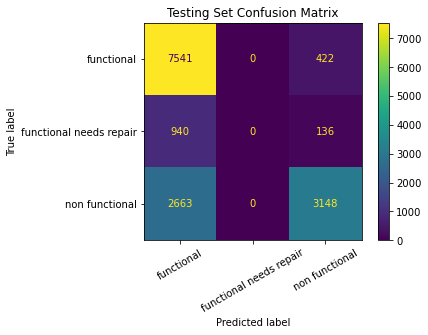

In [26]:
metrics_matrix(svc_clf, X_train, y_train, X_test, y_test)

The SVC model yeilded some funky results. First notice the bright yellow square in the top left, the SVC model correctly predicted more functional wells than either of the two other models. I breifly wondered why, until I saw the middle column. The SVC decided to make this a binary classification and predicted a total of zero rows as the 'functional needs repair' class. These missed guesses are probably padding the success of the functional class, which is also the majority class and easy to predict just based on its higher frequency. 

Considering that the SVC completely ignored one of the target classes, and took about 30 times as long to do it, I would not move forward with tuning this model or attempting future iterations, the other two did more than well enough to use. Maybe, in a situation where the Tanzanian Ministry of Water decided to make their well status binary I would consider trying an SVC again.. maybe...

## Next Steps

As mentioned above, next steps for this model include speaking with the Tanzanian Ministry of Water to determine exactly how they would approach pump repair and if that should influence model building. Also getting more complete information on the columns from them would be helpful, eg. what units is the total static head column is in, and getting a better understanding of the geographic regions and types of pumps.

Exploring the variance and correlation of the categorical columns will help to elimate some of the more useless features and reduce overfitting, or fitting to noise, in the Random forest model.

Once we have been able to successfuly populate all the unknown pump statuses, we can find the best ways to address repairs. One example of this might be concentrating resources into the areas that are most in need of repairs. Here is an example map showing how many repairs are needed in each ward.

<img src='images/ward_repairs_map.jpg'>


And many maps and similar analyses can be performed. As another example, the next steps I would take would be to find not just the areas with the most repairs, but the areas with both high repairs and high population. Or, just the count of certain types of pumps in need of repair. The possibilities are endless and can be discussed with the Tanzanian Ministry of Water.

#### Thanks for reading!